# `DataPipeline1`- Basic Crude pipeline

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from src.preprocessing import *

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

In [4]:
from sklearn.pipeline import Pipeline
from src.utils import print_params
from src.preprocessing import Passthrough

In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


In [6]:
from src.utils import load_data
dfX, dfy = load_data(return_X_y=True)
df_test = load_data('test')
dfX_test = df_test.drop('PassengerId', axis=1)

In [7]:
def missing_clmns(df):
    df_na_count = df.isna().sum(axis=0)
    return df_na_count[df_na_count > 0]

In [8]:
train_miss = missing_clmns(dfX)
train_miss

Age         177
Cabin       687
Embarked      2
dtype: int64

In [9]:
test_miss = missing_clmns(dfX_test)
test_miss

Age       86
Fare       1
Cabin    327
dtype: int64

In [10]:
train_miss.index.union(test_miss.index)

Index(['Age', 'Cabin', 'Embarked', 'Fare'], dtype='object')

So we need to 
- implement `Imputer` for these columns or 
- drop them altogether or 
- encode the missing value with a different category
- in the `prepare_data` transformer, we can choose to drop the NaN values and then train the model
    - or is it more advised to add a missing indicator and train the model?
   

# Pipeline outline:

1. Drop Name, Ticket - requires Feature Engineering
2. OneHotEncoder for Sex, Embarked
3. Drop Cabin - requires Feature Engineering/(?And Not Imputation)
4. Impute Age with mean
5. Drop NaN rows in Embarked
6. Scaling Age and Fare

MLModel: RandomForestClassifer

## Prepare data
These steps include the sample size altering steps.

## `prepare`

In [11]:
prepare_data = Pipeline([
    ('nan_drpr', NaNDropper(['Embarked']))
])

dfX_pre, dfy_pre = prepare_data.fit_transform(dfX, dfy)

### Hyperparameters

In [12]:
print_params(prepare_data)

['memory', 'steps', 'verbose', 'nan_drpr', 'nan_drpr__key']


## `preprocess`
These include the sklearn compatible steps but can be divided into sequential and parallel steps

## Variant 1
### Scaling applied to only continuous columns

In [13]:
imp_scale = Pipeline([
    ('imp', SimpleImputer()),
    ('scale', StandardScaler())
], 'passthrough')

imp_enc = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('enc', OneHotEncoder(drop='first'))
])

preprocess_data = ColumnTransformer([
    ('clmn_drp', 'drop', ['Name', 'Ticket', 'Cabin', 'PassengerId']),
    ('enc', OneHotEncoder(drop='first'), ['Sex']),
    ('imp_enc', imp_enc, ['Embarked']),
    ('imp_scale', imp_scale, ['Age', 'Fare']),
], 'passthrough')

## Variant 2 (I will choose this one for further analyses)
### Scaling applied to all columns as well as OneHot columns

In [14]:

imp_enc = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent'), ),
    ('enc', OneHotEncoder(drop='first'))
])


clmn_trnsfrm = ColumnTransformer([
    ('clmn_drp', 'drop', ['Name', 'Ticket', 'Cabin']),
    ('enc', OneHotEncoder(drop='first'), ['Sex']),
    ('imp_enc', imp_enc, ['Embarked']),
    ('imp', SimpleImputer(), ['Age', 'Fare'])
], 'passthrough')


preprocess_data = Pipeline([
    ('clmn_trnsfrm', clmn_trnsfrm),
    ('scale', StandardScaler())
])


### This would be an interesting functionality to add, wherein, just to experiment, initially we apply scaling to select columns, and then have `modify` option to apply it to all columns just at the end before fitting the model


### Repeat the below process with `unprepared ` i.e. dfX, dfy and `prepared` i.e. dfX_pre, dfy_pre data

## `pipeline`

In [34]:
pipe = Pipeline([
    ('preprocess', preprocess_data),
    ('ml', KNeighborsClassifier())
])
pipe.fit(dfX, dfy);

### Training score

In [37]:
pipe.score(dfX, dfy)

0.8653198653198653

### Crossvalidation score

In [38]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
skf = StratifiedKFold(n_splits=5)
cross_val_score(pipe, dfX, dfy).mean()

0.8080660347749671

### Hyperparameters

In [39]:
print_params(preprocess_data)

['memory',
 'steps',
 'verbose',
 'clmn_trnsfrm',
 'scale',
 'clmn_trnsfrm__n_jobs',
 'clmn_trnsfrm__remainder',
 'clmn_trnsfrm__sparse_threshold',
 'clmn_trnsfrm__transformer_weights',
 'clmn_trnsfrm__transformers',
 'clmn_trnsfrm__verbose',
 'clmn_trnsfrm__clmn_drp',
 'clmn_trnsfrm__enc',
 'clmn_trnsfrm__imp_enc',
 'clmn_trnsfrm__imp',
 'clmn_trnsfrm__enc__categories',
 'clmn_trnsfrm__enc__drop',
 'clmn_trnsfrm__enc__dtype',
 'clmn_trnsfrm__enc__handle_unknown',
 'clmn_trnsfrm__enc__sparse',
 'clmn_trnsfrm__imp_enc__memory',
 'clmn_trnsfrm__imp_enc__steps',
 'clmn_trnsfrm__imp_enc__verbose',
 'clmn_trnsfrm__imp_enc__imp',
 'clmn_trnsfrm__imp_enc__enc',
 'clmn_trnsfrm__imp_enc__imp__add_indicator',
 'clmn_trnsfrm__imp_enc__imp__copy',
 'clmn_trnsfrm__imp_enc__imp__fill_value',
 'clmn_trnsfrm__imp_enc__imp__missing_values',
 'clmn_trnsfrm__imp_enc__imp__strategy',
 'clmn_trnsfrm__imp_enc__imp__verbose',
 'clmn_trnsfrm__imp_enc__enc__categories',
 'clmn_trnsfrm__imp_enc__enc__drop',
 'c

### Should I use `StratifiedKfold`?

If the distribution of the test dataset is sufficiently different from the train, I **SHOULD NOT** use `StratifiedKfold`


Refer : 
- [Stackexchange: When to use stratified k-fold](https://stats.stackexchange.com/questions/401526/when-to-use-stratified-k-fold)
- [Difference between stratifiedkfold and stratifiedshufflesplit](https://stackoverflow.com/questions/45969390/difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn)

### Let's see if this is the case

In [40]:
dfX_test = load_data('test')
dfX_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### First check if the pipeline can predict on the test dataset

In [53]:
pred = pipe.predict(dfX_test)
pred

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

### Function to create a submission dataframe and a file 

In [103]:
from src.config import get_config
from src.utils import load_data
import pandas as pd
from datetime import datetime 
import os

config_params = get_config()

def get_submission_name(dp, add_time=False):
    if not add_time:
        return '_'.join([dp.name, "submission.csv"])
    else:
        now = datetime.now()
        now = now.strftime("%d%m%y%H%M")
        return  '_'.join([dp.name, now, "submission.csv"])
        
        

def create_submission(pred, outname=None, outdir=None):
    ''' 
    Create submission dataframe and optionally write out a file
    
    '''
    psngr_id = load_data('test')['PassengerId']
    sub_df = pd.DataFrame({'PassengerId': psngr_id, 'Survived': pred})
    
    if outname is not None:
        if outdir is None:
            submission_dir = config_params['SUBMISSION_DIR']
        else:
            submission_dir = outdir
            
    elif outdir is not None:
        raise ValueError('Please provide outname')
            
    outfile = os.path.join(submission_dir, outname)    
    sub_df.to_csv(outfile, index=False)
    print(f'Created submission file at {outfile}')
        
    return sub_df

In [102]:
get_submission_name(dp1, add_time=True)

'dp1_1505201850_submission.csv'

In [89]:
all([False])

False

In [84]:
from src.pipeline import dp1

In [63]:
create_submission(pred, outfile="../../data/submission/dp1_submission.csv")

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [55]:
get_submission_df(pred)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


### Concat the train and test datasets to compare them

In [90]:
df_all = pd.concat([df, dfX_test], keys=['train', 'test'], names=['dataset'], axis=0).droplevel(1).reset_index()
df_all.head()

,dataset,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,train,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,train,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,train,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,train,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,train,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Let's first compare `Age`, `Fare`

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

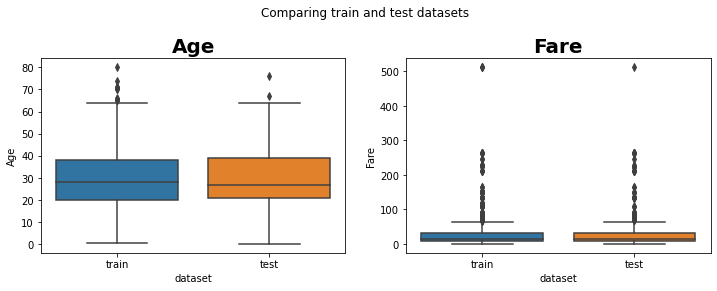

In [92]:
fig, axn = plt.subplots(1, 2, figsize=(12, 4))

for ax, clmn in zip(axn, ['Age', 'Fare']):
    sns.boxplot(x='dataset', y=clmn, data=df_all, ax=ax);
    ax.set_title(clmn, fontdict={'weight': 'bold', 'size': 20})
    
fig.suptitle('Comparing train and test datasets')
fig.subplots_adjust(top=0.8)

Both of the distributions look pretty similiar

In [93]:
def boxplot_compare(df1, df2, clmns: list, nrow, ncol, keys=None, figsize=None, **kwargs):
    
    fig, axn = plt.subplots(nrow, ncol, figsize=figsize)
    
    if len(clmns) == 1:
        axn = [axn]
        
    if keys is None:
        keys = ['df1', 'df2']
    
        
    df_all = pd.concat([df1[clmns], df2[clmns]], keys=keys, 
                       names=['dataset'], axis=0).droplevel(1).reset_index()
    

    for ax, clmn in zip(axn, clmns):
        sns.boxplot(x='dataset', y=clmn, data=df_all, ax=ax, **kwargs);
        ax.set_title(clmn, fontdict={'weight': 'bold', 'size': 20})
        
        
    title = 'Comparing {} and {} datasets'.format(*keys)
    fig.suptitle(title)
    fig.subplots_adjust(top=0.8)
    
    return fig, axn

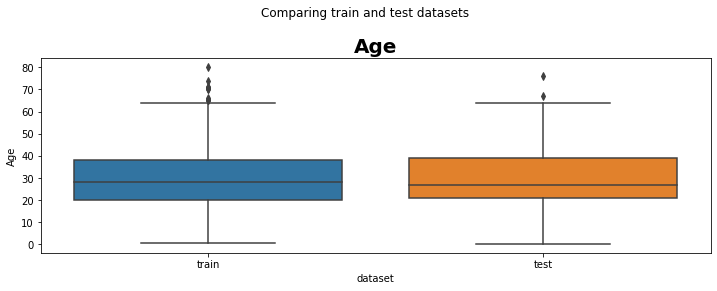

In [94]:
boxplot_compare(df, dfX_test, ['Age'], 1, 1, keys=['train', 'test'], figsize=(12, 4));

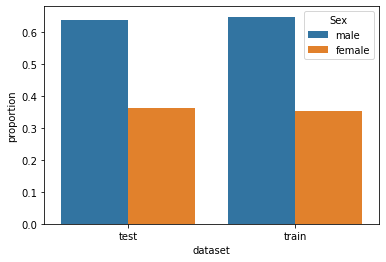

In [95]:
(df_all
 .groupby('dataset')['Sex']
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, 'data'), x='dataset', y='proportion', hue='Sex'))

In [96]:
def barplot_compare(df1, df2, clmns: list, nrow, ncol, keys=None, figsize=None, **kwargs):
    fig, axn = plt.subplots(nrow, ncol, figsize=figsize)
    
    if len(clmns) == 1:
        axn = [axn]
        
    if keys is None:
        keys = ['df1', 'df2']
    
        
    df_all = pd.concat([df1[clmns], df2[clmns]], keys=keys, 
                       names=['dataset'], axis=0).droplevel(1).reset_index()
    

    for ax, clmn in zip(axn, clmns):
        (df_all
         .groupby('dataset')[clmn]
         .value_counts(normalize=True)
         .rename('proportion')
         .reset_index()
         .pipe((sns.barplot, 'data'), x='dataset', y='proportion', hue=clmn, ax=ax))
        
        ax.set_title(clmn, fontdict={'weight': 'bold', 'size': 20})
        
        
    title = 'Comparing {} and {} datasets'.format(*keys)
    fig.suptitle(title)
    fig.subplots_adjust(top=0.8)
    
    return fig, axn
    

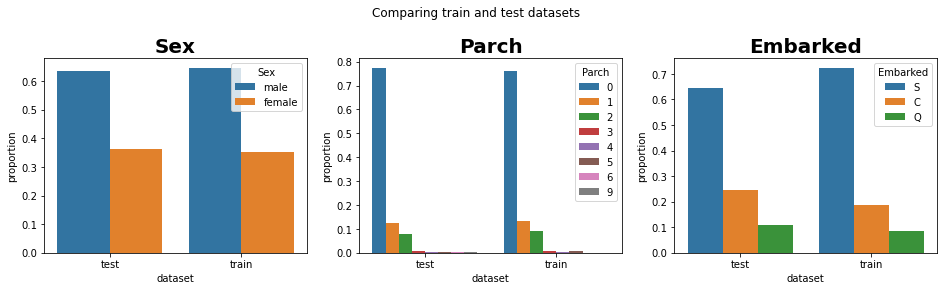

In [97]:
barplot_compare(df, dfX_test, ['Sex', 'Parch', 'Embarked'], 1, 3, keys=['train', 'test'], figsize=(16, 4));

Here also the distributions look very similiar. So I think I can go ahead with `StratifiedKFold`

## Create a `ComparisionPlotter` class

In [98]:
class ComparisionPlotter:
    
    # store concatenated df and reuse it to make plots
    # but if the df is too large give the option of not concatenating
    pass
    

## Perfrom `GridSearchCV`

In [99]:
from sklearn.model_selection import GridSearchCV

In [100]:
skf = StratifiedKFold(n_splits=5)
rskf = RepeatedStratifiedKFold(n_splits=5, random_state=1)
cross_val_score(pipe, dfX_pre, dfy_pre, cv=skf).mean()

0.8087919761315305

In [101]:
print_params(pipe)

['memory',
 'steps',
 'verbose',
 'preprocess',
 'ml',
 'preprocess__memory',
 'preprocess__steps',
 'preprocess__verbose',
 'preprocess__clmn_trnsfrm',
 'preprocess__scale',
 'preprocess__clmn_trnsfrm__n_jobs',
 'preprocess__clmn_trnsfrm__remainder',
 'preprocess__clmn_trnsfrm__sparse_threshold',
 'preprocess__clmn_trnsfrm__transformer_weights',
 'preprocess__clmn_trnsfrm__transformers',
 'preprocess__clmn_trnsfrm__verbose',
 'preprocess__clmn_trnsfrm__clmn_drp',
 'preprocess__clmn_trnsfrm__enc',
 'preprocess__clmn_trnsfrm__imp',
 'preprocess__clmn_trnsfrm__enc__categories',
 'preprocess__clmn_trnsfrm__enc__drop',
 'preprocess__clmn_trnsfrm__enc__dtype',
 'preprocess__clmn_trnsfrm__enc__handle_unknown',
 'preprocess__clmn_trnsfrm__enc__sparse',
 'preprocess__clmn_trnsfrm__imp__add_indicator',
 'preprocess__clmn_trnsfrm__imp__copy',
 'preprocess__clmn_trnsfrm__imp__fill_value',
 'preprocess__clmn_trnsfrm__imp__missing_values',
 'preprocess__clmn_trnsfrm__imp__strategy',
 'preprocess__c

In [102]:
param_grid = {'ml__n_neighbors': range(1, 11, 2),
              'ml__p': [1, 2, 3, 4],
              'preprocess__clmn_trnsfrm__imp__strategy': ['median', 'mean']}

In [103]:
grid = GridSearchCV(pipe, param_grid, cv=skf)
grid.fit(dfX_pre, dfy_pre);

In [104]:
print(grid.best_params_)
print(grid.best_score_)

{'ml__n_neighbors': 9, 'ml__p': 1, 'preprocess__clmn_trnsfrm__imp__strategy': 'mean'}
0.8166634926680633


## Try various models with the default hyperparameters

In [112]:
from src.pipeline import dp1
pipe = dp1.get_pipeline()

models = [
    RidgeClassifier(),
    LogisticRegression(solver="liblinear"),  # liblinear is better for small datasets
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=1),
    SVC(),
    RandomForestClassifier(random_state=1),
    BaggingClassifier(random_state=1)
]

In [113]:
grid = GridSearchCV(pipe, param_grid, cv=skf)
grid.fit(dfX_pre, dfy_pre);

print(grid.best_params_)
print(grid.best_score_)

{'ml': SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'ml__C': 100, 'ml__gamma': 0.01}
0.8279438837046911


So I can get \~82% accuracy by no hyperparameter tuning in the pipeline by using `SVC`. Nice! :D <br/>

<font color='red'>DOUBT</font>: Do I need to separately see the OOB accuracy for `RandomForestClassifier`?

In [221]:
import seaborn as sns

In [222]:
res = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.020877,0.000633,0.005900,0.000287,"SVC(C=1.0, break_ties=False, cache_size=200, c...","{'clf': SVC(C=1.0, break_ties=False, cache_siz...",0.859551,0.848315,0.786517,0.820225,0.853107,0.833543,0.027078,1
2,0.011957,0.000992,0.011447,0.001087,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'clf': KNeighborsClassifier(algorithm='auto',...",0.831461,0.825843,0.769663,0.803371,0.813559,0.808779,0.021853,2
6,0.139687,0.002569,0.013279,0.000538,"RandomForestClassifier(bootstrap=True, ccp_alp...","{'clf': RandomForestClassifier(bootstrap=True,...",0.786517,0.865169,0.764045,0.780899,0.819209,0.803168,0.035792,3
7,0.029854,0.004641,0.006119,0.000662,"BaggingClassifier(base_estimator=None, bootstr...","{'clf': BaggingClassifier(base_estimator=None,...",0.775281,0.848315,0.764045,0.780899,0.836158,0.800940,0.034368,4
1,0.012855,0.000117,0.005102,0.000109,"LogisticRegression(C=1.0, class_weight=None, d...","{'clf': LogisticRegression(C=1.0, class_weight...",0.820225,0.786517,0.758427,0.814607,0.813559,0.798667,0.023270,5


In [223]:
from src.plotting import plot_grid_results

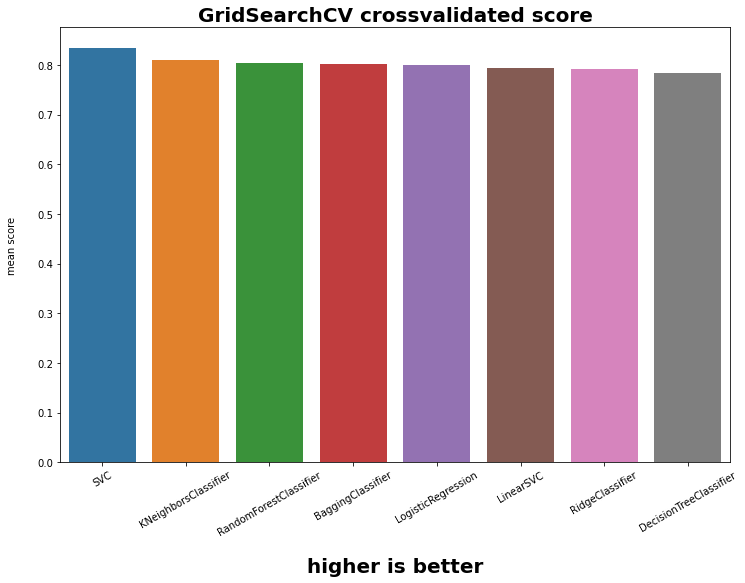

In [224]:
plot_grid_results(grid, 'ml', 'score');

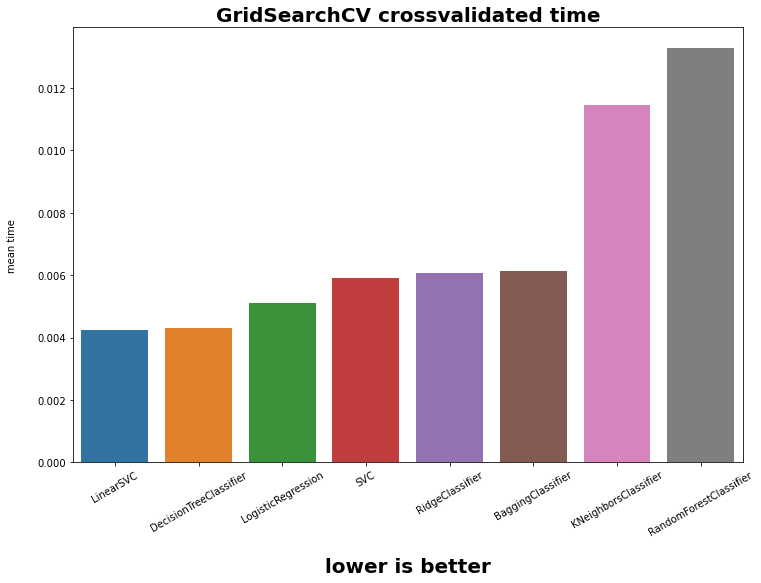

In [225]:
plot_grid_results(grid, 'ml', 'time');

Here is how I think performing the initial no tuning pipeline with different ML models could help:

1. Examine top n models with the best score and the best time
2. Discard absolute worst ML models